# Glued Trees Algorithm
Consider a network of two mirrored binary trees connected to each other, where the outermost nodes of each tree are connected to two random nodes in the other tree. This structure has $2n$ columns and $2^{n+1}-2$ nodes in total, as shown in the diagram below. Each node in the structure has a secret key in the form of a random bit string of size $2n$, and you are given oracular access to the network such that you can query a node using its key to get the keys of its neighbors. Given the key of the entrance node, your goal is to find the key of the exit node as efficiently as possible.

![png](figures/glued_trees_diagram.png)

If you play this game yourself or program an algorithm to do so, you quickly run into a major problem: since you don't know the specific nodes on the tree corresponding to the interior keys, you get lost in the structure once you reach the area between the two trees. There is no way to guarantee a solution to this problem—using a classical computer—that doesn't require you to check every node in the worst case.

There is a way to solve this problem efficiently, however, on the order of the total number of *columns* of the structure instead of the nodes, using a quantum computer! This paper [[1](#GluedTrees)] published in December 2023 describes a quantum approach to solving this algorithm by considering the structure as a system of coupled harmonic oscillators attached by springs. A quantum computer can use Hamiltonian simulation to simulate this classical system efficiently. If you apply a push to the oscillator representing the entrance node and treat the interactions between nodes as queries, you can "reach" the exit node (trigger a spike in its oscillatory movement) in time $2n$, offering linear efficiency as opposed to exponential efficiency.

While this notebook follows the algorithm described by the 2023 paper, it should be noted that this problem was first set out in this paper from October 2002 [[2](#QuantumWalk)].

The following code segment imports all the necessary libraries for this notebook. NetworkX is required for the `generate_pauli_list` function, but the Pauli lists for 10 and 20 qubits (the examples in this notebook) have already been generated and cached in the `glued_trees_cache.json` file. However, if you would like to try recalculating the Pauli lists or calculating them for other qubit sizes, uncomment the line at the bottom of the code segment.

In [1]:
# install required modules
!pip install jsonpickle
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 534.9 kB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import json
import random

import jsonpickle
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from classiq import *
from classiq.execution import ExecutionPreferences

# import networkx as nx

## Quantum Algorithm
To model the columns of the glued trees structure as a system of coupled harmonic oscillators, we consider a matrix $\mathbf{A}$ of size $N \times N$ corresponding to the nodes of the glued trees structure, such that $N=2^{n+1}-2$ and $n$ is the number of columns of one of the two glued trees. This matrix is defined as $\mathbf{A}:=3(\mathbf{1}_N)-A$, where $A$ is the adjacency matrix of the glued trees system using any ordering. 

For demonstration purposes, we use a simple linear ordering of this adjacency matrix such that the entrance node is first and the exit node is last. This matrix is symmetrical and takes the following shape:

![png](figures/A_matrix.png)

As shown in further detail in the paper, we can define a block Hamiltonian $\mathbf{H}$ such that

$$
\mathbf{H} := -\begin{pmatrix}
\mathbf{0} & \mathbf{B} \\
\mathbf{B}^† & \mathbf{0}
\end{pmatrix}
$$

where $\mathbf{B}$ is any $N \times M$ matrix such that $\mathbf{B}\mathbf{B}^†=\mathbf{A}$. However, to use this matrix $\mathbf{H}$ for Hamiltonian simulation, it must have a size corresponding to a power of two, while $\mathbf{A}$ is size $N \times N$. We can deal with this by ensuring that $\mathbf{B}$ is size $N \times (N+4)$, so the resulting Hamiltonian $\mathbf{H}$ is a square matrix with side length $2N+4 = 2(2^{n+1}-2)+4 = 2^{n+2}$. This means that a glued trees system with $n$ columns for one tree can be simulated using $n+2$ qubits.

In this notebook, we generate the matrix $\mathbf{A}$ by building the glued trees structure using the NetworkX library such that the nodes are labeled in order from the entrance to exit node and using the `nx.adjacency_matrix` function to generate an adjacency matrix using that ordering. We decompose $\mathbf{A}$ using [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) to get a square matrix where its product with its conjugate transpose is equal to $\mathbf{A}$. This matrix is the same size as $\mathbf{A}$, however, so we must pad it with four columns of zeroes to get our matrix $\mathbf{B}$ of size $N \times (N+4)$ so $\mathbf{H}$ has a size corresponding to a power of two. We can then create the block Hamiltonian with the proper size using $\mathbf{B}$ and $\mathbf{B}^†$, and generate its full Pauli list using the Classiq built-in `matrix_to_hamiltonian` function.

All Pauli list outputs are cropped so they have no more than 200 terms. This is to ensure that the circuit depth is at a reasonable range (in the low thousands) given the limits of current quantum hardware. As a result of this approach, as the number of qubits increases, the accuracy of the Pauli list in comparison to the matrix it represents diminishes so the circuit depth remains roughly constant.

The Pauli list representation of $\mathbf{H}$ for qubit sizes small enough to calculate (12 qubits and lower) are generated and cropped using the `generate_pauli_list` function, which uses an ad hoc approach that tries to represent the Pauli list as a whole as accurately as possible using only the 200 ostensibly most relevant terms to simulate the system.

The cropping algorithm, defined in the `crop_pauli_list` function, first selects 120 terms (60%) by going through each character position from the end to the start and picking the Pauli terms with the largest coefficients that contain each of the four possibilities ($I$, $X$, $Y$, $Z$) at that character position. If all positions are exhausted before reaching 120 terms, the algorithm takes another pass through the character positions until 120 are selected. The other 80 terms (40%) are selected by picking the 80 remaining terms with the largest coefficients. The algorithm balances important high-coefficient terms with diversity in the 200 selected terms.

The Pauli lists for qubit sizes too large to fully calculate (greater than 12 qubits) are approximated by padding with the second character of the Pauli strings of the largest cropped Pauli list that can be generated in reasonable time, as this follows a pattern present in the vast majority of strings in the cropped Pauli list.

In [4]:
def crop_pauli_list(pauli_list, size):
    if len(pauli_list) <= size:
        return pauli_list
    result = []
    idx = 0
    while len(result) < round(size * 0.6):
        for i in range(len(pauli_list[0].pauli) - 1, -1, -1):
            for k in pauli_list:
                if (
                    k.pauli[i] == [Pauli.I, Pauli.X, Pauli.Y, Pauli.Z][idx % 4]
                    and k not in result
                ):
                    result.append(k)
                    break
            idx += 1
    for i in pauli_list:
        if len(result) >= size:
            break
        if i not in result:
            result.append(i)
    return result


def generate_pauli_list(qubits):
    dim = qubits - 2
    T1 = nx.balanced_tree(2, dim - 1)
    T2 = nx.relabel_nodes(T1, lambda x: 2 ** (dim + 1) - 3 - x)
    T = nx.union(T1, T2)
    edges = {i: 0 for i in range(2**dim - 1, 2 ** (dim - 1) + 2**dim - 1)}
    for i in range(2 ** (dim - 1) - 1, 2**dim - 1):
        nums = [
            j for j in range(2**dim - 1, 2 ** (dim - 1) + 2**dim - 1) if edges[j] < 1
        ]
        if len(nums) == 0:
            nums = [
                j
                for j in range(2**dim - 1, 2 ** (dim - 1) + 2**dim - 1)
                if edges[j] < 2
            ]
        vals = random.sample(nums, k=2)
        for j in vals:
            edges[j] += 1
        T.add_edges_from([(i, vals[0]), (i, vals[1])])
    A = 3 * np.identity(2 ** (dim + 1) - 2) - np.array(
        nx.adjacency_matrix(T, nodelist=sorted(T.nodes())).todense()
    )
    B = np.hstack((np.linalg.cholesky(A), np.zeros((2 ** (dim + 1) - 2, 4))))
    H = -np.block(
        [
            [np.zeros((B.shape[0], B.shape[0])), B],
            [B.conj().T, np.zeros((B.shape[1], B.shape[1]))],
        ]
    )
    result = matrix_to_hamiltonian(H)
    return crop_pauli_list(
        sorted(result, key=lambda x: abs(x.coefficient), reverse=True), 200
    )


def pauli_str(qubits, recalculate=False):
    with open("glued_trees_cache.json", "r") as f:
        cache = json.load(f)
    if not recalculate and str(qubits) in cache:
        return jsonpickle.decode(cache[str(qubits)])
    if qubits > 12:
        return [
            PauliTerm(
                [i.pauli[0]] + [i.pauli[1]] * (qubits - len(i.pauli)) + i.pauli[1:],
                i.coefficient,
            )
            for i in generate_pauli_list(12)
        ]
    return generate_pauli_list(qubits)

We are now ready to run our main execution function, `run_point`. This function takes in the number of qubits `qubits` and the time `t` to perform Hamiltonian simulation $e^{-it\mathbf{H}}$ using the `exponentiation_with_depth_constraint` function in the Classiq software development kit. 

The `max_depth` parameter is set to 1400, which is around the range of the current limit for comprehensible results in state-of-the-art quantum computers. The `num_shots` parameter is set to 8192 to give enough room for significant spikes in a state to be apparent, given the high number of total possible states.

The resulting quantum state can be written as follows:

$$
\begin{aligned}
|\psi(t)\rangle &\propto \begin{pmatrix}
\dot{\vec{x}}(t) \\
i\mathbf{B}^{†} \vec{x}(t) 
\end{pmatrix} \\
\begin{pmatrix}
\dot{\vec{x}}(t) \\
i\mathbf{B}^{†} \vec{x}(t) 
\end{pmatrix} &= e^{-it\mathbf{H}} \begin{pmatrix}
\dot{\vec{x}}(0) \\
i\mathbf{B}^{†} \vec{x}(0) 
\end{pmatrix}
\end{aligned}
$$

where $\vec{x}(0)=(0,0,\dots,0)^T$ and $\dot{\vec{x}}(0)=(1,0,\dots,0)^T$ using a linear ordering of nodes. 

Since the speed of the entrance node oscillator $|\dot{x}_1(t)|$ is represented by the quantum state $|0\rangle$ and should have probability 1 at $t=0$, there is no specific state preparation necessary for this system. It should also be noted that since our matrix $\mathbf{B}^†$ is padded with four rows of zeroes, the highest four quantum states do not correspond to the displacement or speed of any oscillator. This means that the quantum state representing the speed of the exit node oscillator $|\dot{x}_N(t)|$, which is what we are most interested in, corresponds to $|N-1\rangle=|2^{n+1}-3\rangle$. We track this particular quantum state at time $t \approx 2n$, expecting a spike that represents the system of oscillators "reaching" the exit node from the initial push to the entrance node.

We run the `run_point` function through a helper function `run_range`, which executes it 13 times in total for a given qubit size, spanning from $t=2n-12$ to $t=2n+12$ in two-second intervals. This range gives time to observe oscillation occurring at the state value corresponding to $|\dot{x}_N(t)|$ while also being close enough around $t=2n$, the time where we expect a spike.

In [5]:
# set global lists for testing all qmods and qprogs in notebook
qmods = []
qprogs = []


def run_point(qubits, t, pauli_list):
    @qfunc
    def main(state: Output[QArray[QBit]]) -> None:
        allocate(len(pauli_list[0].pauli), state)
        exponentiation_with_depth_constraint(
            pauli_list,
            evolution_coefficient=t,
            max_depth=1400,
            qbv=state,
        )

    execution_preferences = ExecutionPreferences(num_shots=8192)
    model = set_execution_preferences(create_model(main), execution_preferences)
    qmods.append(model)
    quantum_program = synthesize(model)
    qprogs.append(quantum_program)
    job = execute(quantum_program)
    filename = (
        str(qubits)
        + "-qubits/2n"
        + (
            str(t - 2 * qubits + 4)
            if t < 2 * qubits - 4
            else "+" + str(t - 2 * qubits + 4)
        )
    )
    with open("results/" + filename + ".json", "w") as f:
        f.write(job.result_value().model_dump_json())


def run_range(qubits, recalculate=False):
    pauli_list = pauli_str(qubits, recalculate)
    for i in tqdm.tqdm(range(-12, 13, 2)):
        run_point(qubits, 2 * qubits - 4 + i, pauli_list)

The following code segment displays the execution of `run_range` for 10 qubits ($n=8, N=510$), a higher qubit size that is still simulatable. In addition, it is low enough that its Pauli list can still be fully generated and cropped.

This instance of the function takes a few minutes to run. As defined, it uses the cached Pauli list for ten qubits in `glued_trees_cache.json`. To recalculate the Pauli list, ensure that you uncomment and run the two lines at the top of this notebook and add `recalculate=True` as the second parameter to the function:

In [6]:
run_range(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [04:35<00:00, 21.15s/it]


The following code segment, on the other hand, displays the execution of `run_range` for 20 qubits ($n=18, N=524286$), a qubit size that is still simulatable but whose Pauli list cannot be generated and is thus approximated using the Pauli list for 12 qubits.

This instance of the function takes a few minutes to run if the cached Pauli list is used. Since this instance of the function requires generating the Pauli list for 12 qubits, which is very large, it takes much longer to run if you choose to recalculate the Pauli list.

You can also view the `qmod` file for the execution of `run_point` for 20 qubits at $t=2n$, which is saved in this directory as `glued_trees_example.qmod`:

In [7]:
run_range(20)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [07:27<00:00, 34.41s/it]


We can now graph the results we have generated using the simulator, which have been saved in directories in the `results` folder based on their qubit size. The `graph_results` function creates a plot of the proportion of shots for the qubit state $|N-1\rangle$ corresponding to $|\dot{x}_N(t)|$ for a given qubit size from $t=2n-12$ to $t=2n+12$ and saves it in the `figures` folder:

In [8]:
def graph_results(qubits):
    states = [(str(i) if i < 0 else "+" + str(i)) for i in range(-12, 13, 2)]
    times = [2 * qubits - 4 + int(i) for i in states]
    data = []
    for i in states:
        with open("results/" + str(qubits) + "-qubits" + "/2n" + i + ".json", "r") as f:
            j = json.load(f)
            key = str("0" + bin(2 ** (qubits - 1) - 3)[2:])
            data.append(j["counts"][key] / j["num_shots"] if key in j["counts"] else 0)
    plt.plot(times, data)
    plt.xlabel("Time (s)")
    plt.ylabel("Proportion of |" + str(2 ** (qubits - 1) - 3) + "> shots")
    plt.title(
        r"Glued Trees System at $t \approx 2n$ for "
        + str(qubits)
        + r" Qubits ($n="
        + str(qubits - 2)
        + r"$)"
    )
    plt.savefig("figures/" + str(qubits) + "_qubits.png", bbox_inches="tight", dpi=300)
    plt.show()

The following code segment displays the graph for 10 qubits, a qubit size with a generated and cropped Pauli list. As expected, there is a large spike at $t \approx 2n$ indicative of the initial push to the entrance node "reaching" the exit node:

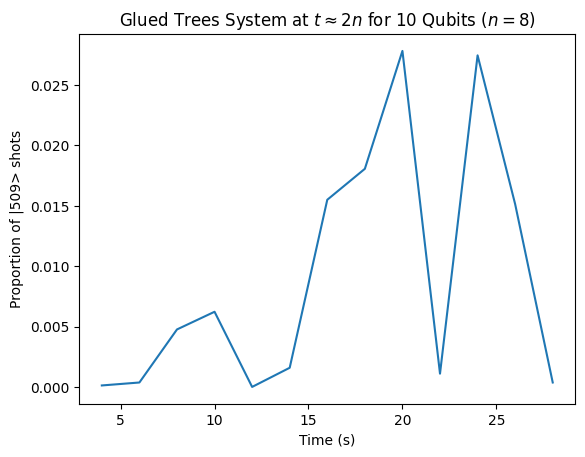

In [9]:
graph_results(10)

The following code segment displays the graph for 20 qubits, a qubit size with an approximated Pauli list. There is a clear spike at $t \approx 2n$ caused by the propagation from the entrance node:

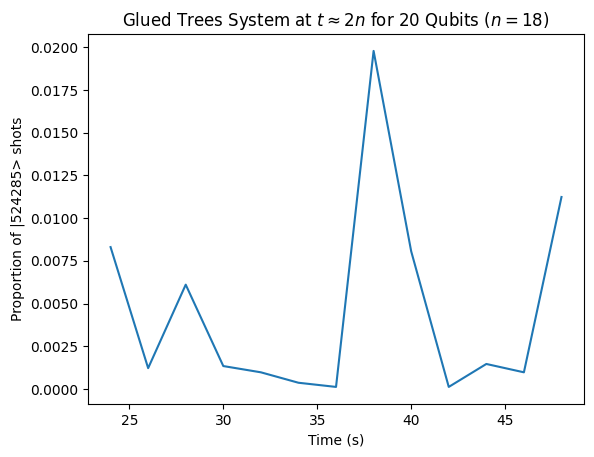

In [10]:
graph_results(20)

Because of the Pauli list cropping, you can also run the algorithm with reasonable accuracy on actual quantum hardware by adding Classiq quantum hardware [cloud providers](https://docs.classiq.io/latest/user-guide/execution/cloud-providers/) as an execution preference in the `run_point` function.

Perhaps the most interesting thing about the glued trees algorithm is that it is a relatively heavy case of using a quantum computer to gain an exponential advantage, usually requiring several executions at different time points to observe the intended result, but it can still execute effectively on present-day quantum hardware due to the Pauli list cropping. Suggestion: Try out the algorithm on both a simulator and quantum hardware for various qubit sizes. 

## References
<a id="GluedTrees">[1]</a> [Babbush, R., Berry, D. W., Kothari, R., Somma, R. D., and Wiebe, N. "Exponential quantum speedup in simulating coupled classical oscillators." Phys. Rev. X 13, 041041 (2023)](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.13.041041).

<a id="QuantumWalk">[2]</a> [Childs, A. M., Cleve, R., Deotto, E., Farhi, E., Gutmann, S., and Spielman, D. A. "Exponential algorithmic speedup by a quantum walk." Proc. 35th ACM Symposium on Theory of Computing (STOC 2003), pp. 59-68](https://arxiv.org/pdf/quant-ph/0209131).
